<a href="https://colab.research.google.com/github/BhachawatSaransh/Smart-Dustbin/blob/main/Smart_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow as tf

In [ ]:
print(tf.version.VERSION)

2.9.2


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parthmahadik","key":"d6a0a9871d79d9f9bc91baf08e43cf38"}'}

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

100% 427M/427M [01:24<00:00, 38.1MB/s]
100% 427M/427M [01:24<00:00, 5.30MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('waste-classification-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/DATASET/TEST/R'))

1112

In [ ]:
# !kaggle kernels output beyzanks/waste-classification-with-cnn -p /path/to/dest

In [ ]:
train_path = "/tmp/DATASET/TRAIN/"
test_path = "/tmp/DATASET/TEST/"

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from glob import glob

In [ ]:
# Visualization
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 9999/9999 [00:06<00:00, 1460.78it/s]


In [ ]:
data.shape

(22564, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'O': 12565, 'R': 9999})

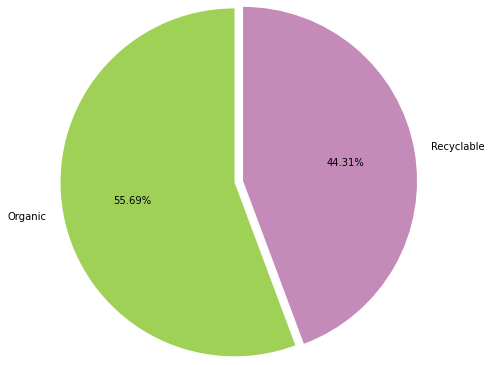

In [ ]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

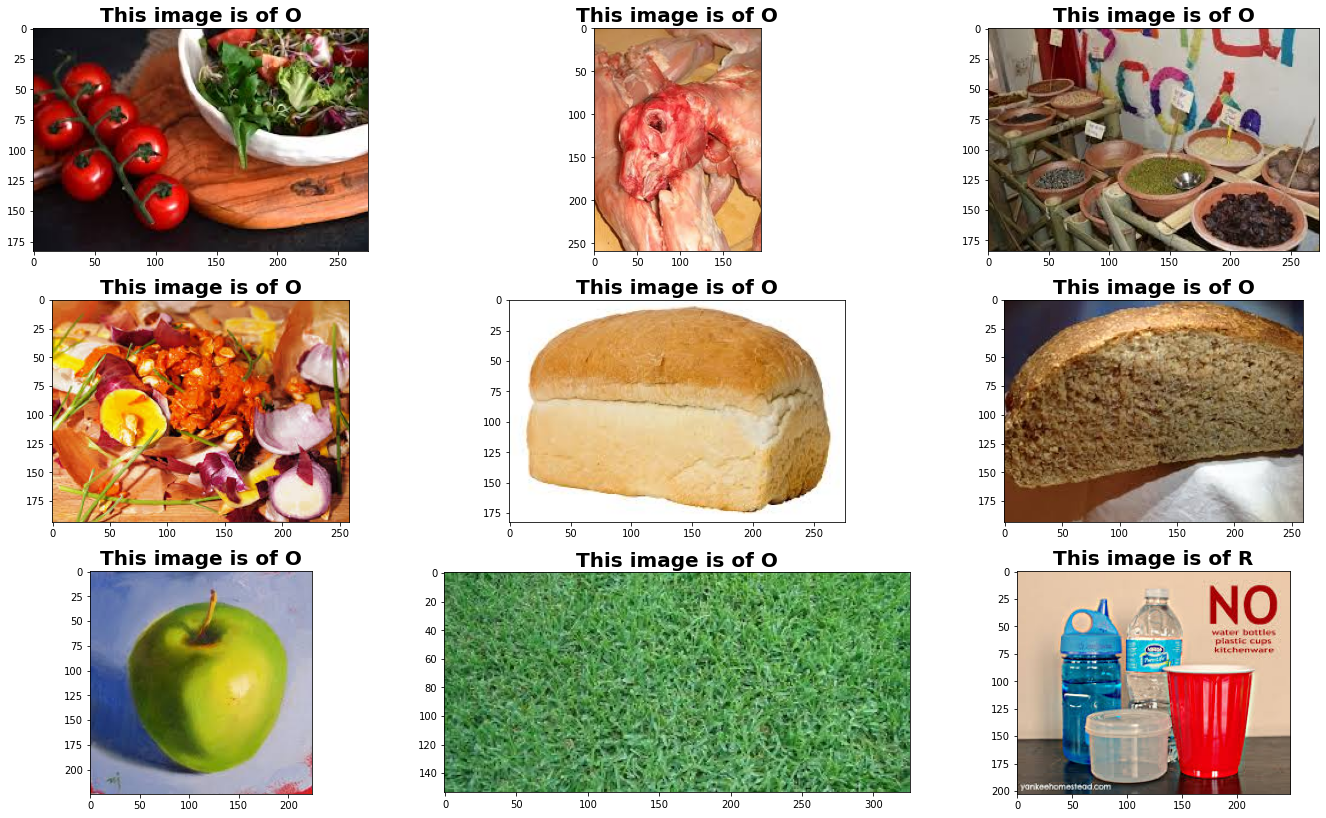

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%9)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])

batch_size = 256

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=10,
        validation_data = test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
89/89 [==============================] - 52s 571ms/step - loss: 0.5330 - accuracy: 0.7771 - val_loss: 0.4143 - val_accuracy: 0.8181
Epoch 2/10
62/89 [===================>..........] - ETA: 14s - loss: 0.4090 - accuracy: 0.8318

KeyboardInterrupt: ignored

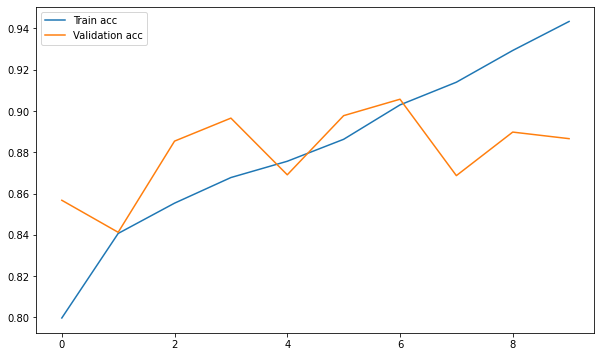

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

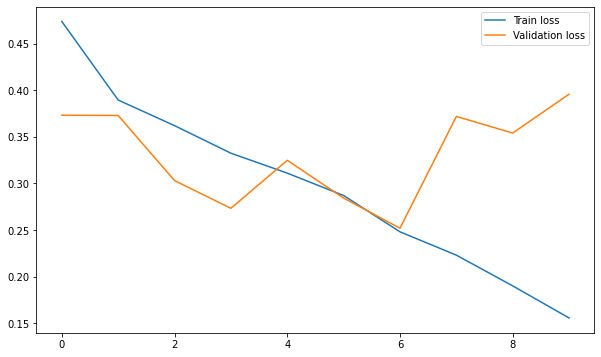

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 [==============================] - 0s 234ms/step
This image -> Organic


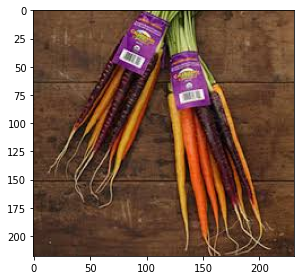

In [ ]:
test_img = cv2.imread("/tmp/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 21ms/step
This image -> Recyclable


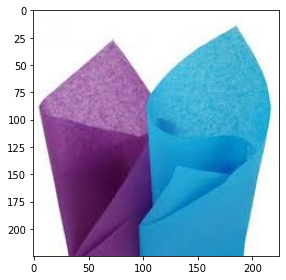

In [ ]:
test_img = cv2.imread("/tmp/DATASET/TEST/R/R_10753.jpg")
predict_func(test_img)

In [ ]:
img_path = cv2.imread("/content/O dustbin.jpeg")
predict_func(img_path)

error: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


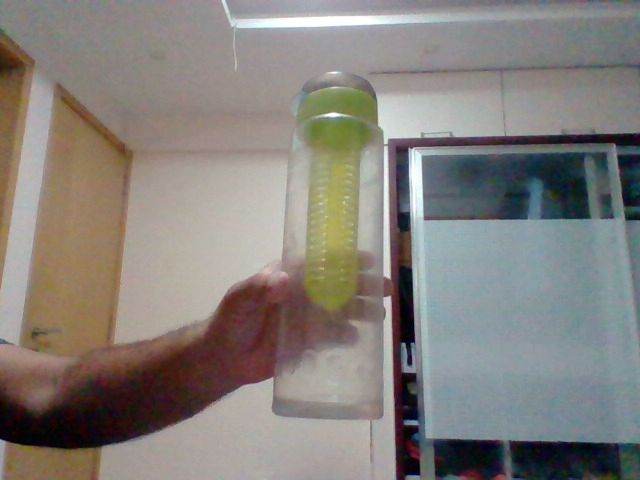

OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'



<Figure size 432x288 with 0 Axes>

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  predict_func(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

1/1 [==============================] - 0s 21ms/step
This image -> Organic


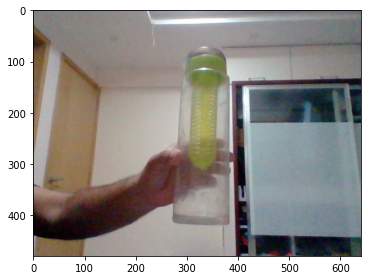

In [ ]:
test_img = cv2.imread("/content/photo.jpg")
predict_func(test_img)

In [ ]:
videoCaptureObject = cv2.VideoCapture(0)
result = True
while(result):
    ret,frame = videoCaptureObject.read()
    # img=predict_func(frame)
    # cv2.imshow("original",np.array(img))
    # out.write(img)
    if(cv2.waitKey(1) & 0xFF==ord('q')):
        break
videoCaptureObject.release()
cv2.destroyAllWindows()

KeyboardInterrupt: ignored

# TEST

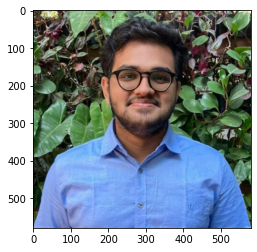

In [ ]:
img_path = "/content/pp1.jpg"
import matplotlib.image as img

predImage = img.imread(img_path)

plt.imshow(predImage)

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
image = Image.open(img_path)
image.size

image = image.resize((224, 224), Image.ANTIALIAS)
image.size

(224, 224)

In [ ]:
img_array = img_to_array(image)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
img_preprocessed = preprocess_input(img_batch)

In [ ]:
predict_func(image)

error: ignored

<Figure size 432x288 with 0 Axes>

NameError: ignored